In [1]:
# First we grab the model and the unembedding weight matrix
import torch
from easy_transformer import EasyTransformer

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f"Using {device} device")
torch.set_grad_enabled(False)

model = EasyTransformer.from_pretrained('gpt2').to(device)

# Convenience function for decoding token
decode = model.tokenizer.decode
encode = model.tokenizer.encode

M_to_V = model.unembed.W_U.data
d_M = model.cfg.d_model
d_V = model.cfg.d_vocab

Using cpu device
Loading model: gpt2


/home/giles/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
Using pad_token, but it is not set yet.


Moving model to device:  cpu
Finished loading pretrained model gpt2 into EasyTransformer!
Moving model to device:  cpu


In [2]:
from sklearn.decomposition import PCA

V_to_M = torch.nn.functional.normalize(torch.linalg.pinv(M_to_V), dim=1)

pca_model = PCA(n_components=d_M)
M_to_D = torch.tensor(pca_model.fit_transform(M_to_V), dtype=torch.float)
D_to_V = torch.tensor(pca_model.components_, dtype=torch.float)
variance = torch.tensor(pca_model.explained_variance_)
V_to_D = torch.matmul(V_to_M, M_to_D)
d_D = d_M

In [3]:
lengths = torch.linalg.vector_norm(V_to_D, dim=1)
values = [(v.item(),i) for i,v in enumerate(lengths)]
values.sort(reverse=True)
for i in range(0, d_V, 100):
    print(f'{i:5}', f'{values[i][0]:20}', f'{decode(values[i][1]):20}')

# I don't know what the significance of these numbers is.

    0    35.03495407104492  Cubs               
  100            32.921875  Polish             
  200    32.60264205932617  Algeria            
  300    32.41712951660156  290                
  400    32.25004577636719  mutant             
  500     32.1168212890625  coal               
  600     32.0102424621582 282                 
  700   31.931928634643555  tablets            
  800    31.84441375732422  BlackBerry         
  900   31.781049728393555  carving            
 1000   31.720104217529297  Cron               
 1100    31.65986442565918  Risk               
 1200   31.610103607177734  importing          
 1300   31.561084747314453  manip              
 1400    31.51361083984375  bulbs              
 1500    31.46949005126953  Farrell            
 1600   31.421260833740234  blends             
 1700    31.38223648071289  logistical         
 1800    31.33391571044922  ballet             
 1900   31.293092727661133  Chargers           
 2000   31.259592056274414  racial      

Text(tensor(-0.9093, requires_grad=True), tensor(16.6958), ' IPM')

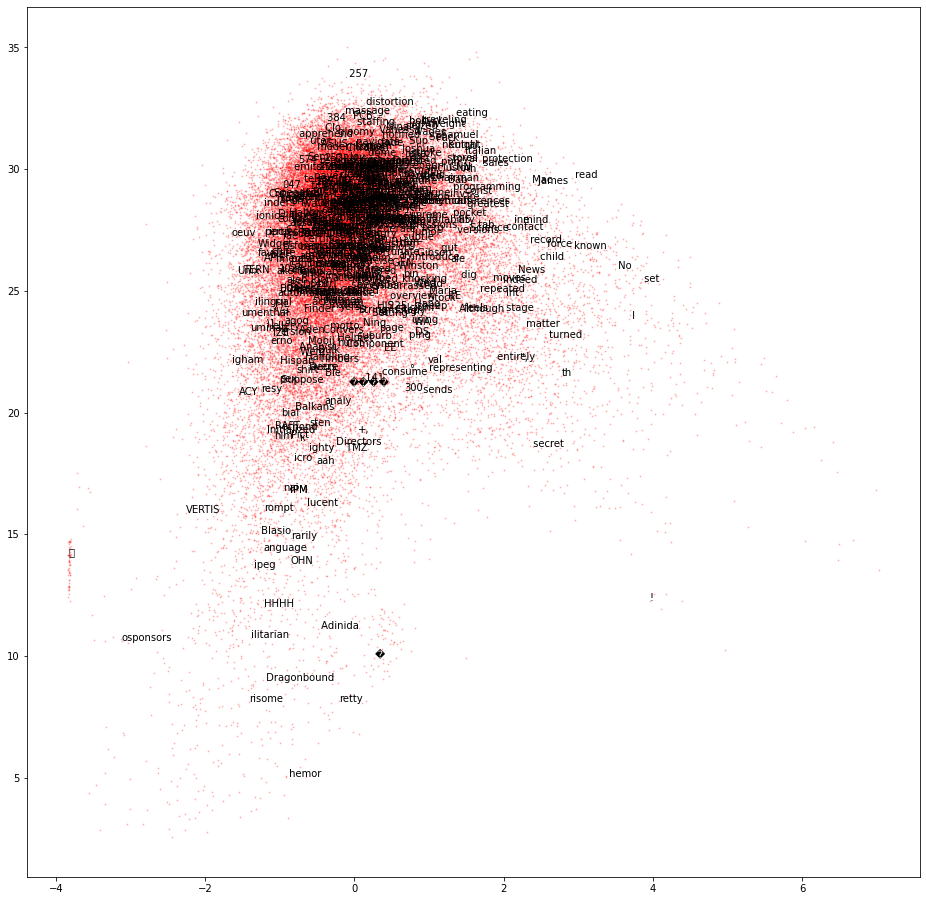

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 16]

plt.scatter(model.unembed.b_U, lengths, s=1, color=(1,0,0,0.2))

for i in range(0, d_V, 100):
    plt.text(model.unembed.b_U[i], lengths[i], decode(i))
plt.text(model.unembed.b_U[i], lengths[i], decode(i))

<BarContainer object of 768 artists>

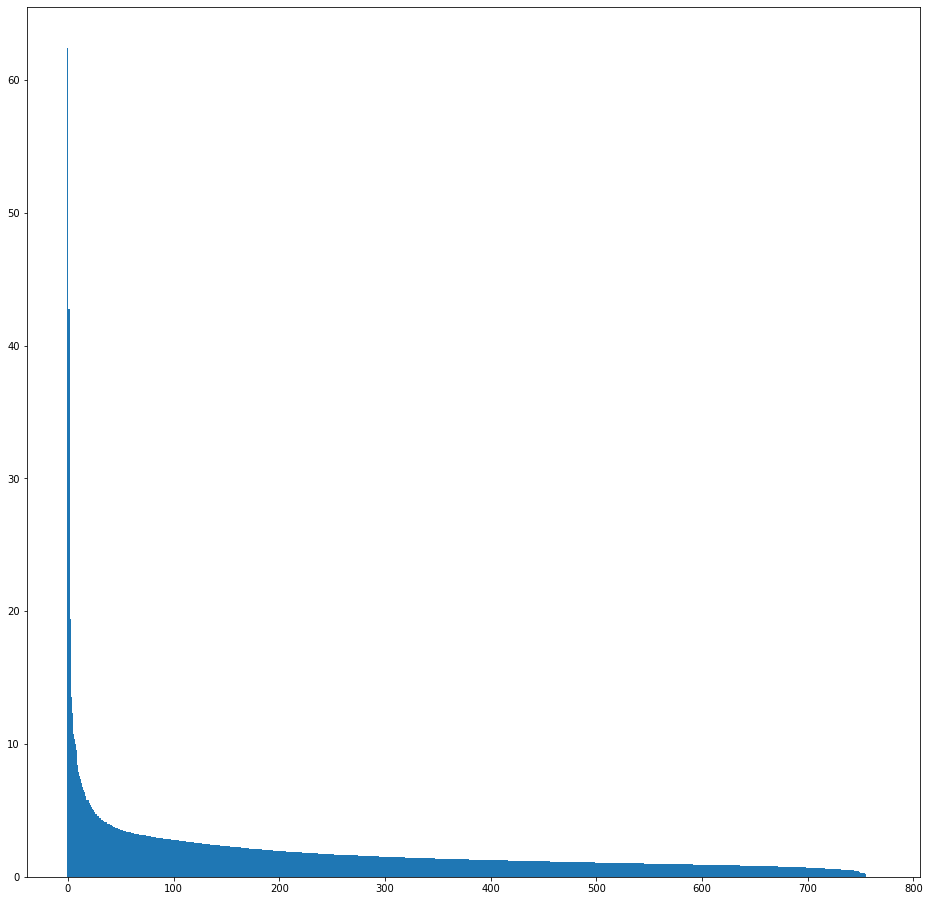

In [12]:
plt.bar(x=range(d_D), height=variance, width=1)

In [13]:
# Can we get away with keeping just a subset of principal components?
keep = 100

M_to_K = M_to_D[:,:keep]
V_to_K = torch.matmul(V_to_M, M_to_K)

example_tokens = [' cat', ' war', ' banana', ' bat', ' bark', ' leaves', ' another', ' that']

def print_similar_trunc(heading, td):
    print(heading, torch.linalg.vector_norm(td).item(), ' TRUNCATED')
    similarity_vec = torch.matmul(V_to_K, td)
    values = [(v.item(), i) for i,v in enumerate(similarity_vec)]
    values.sort(reverse=True)
    for v,i in values[:20]:
        print(f'  {decode(i):20}', f'{v:20}')
    print()

def print_similar(heading, td):
    print(heading, torch.linalg.vector_norm(td).item(), ' FULL')
    similarity_vec = torch.matmul(V_to_D, td)
    values = [(v.item(), i) for i,v in enumerate(similarity_vec)]
    values.sort(reverse=True)
    for v,i in values[:20]:
        print(f'  {decode(i):20}', f'{v:20}')
    print()


for tok in example_tokens:
    t, = encode(tok)
    td = V_to_K[t,:]
    print_similar_trunc(tok, td)
    print_similar(tok, V_to_D[t,:])

 cat 9.611154556274414  TRUNCATED
   cat                    92.37429809570312
   cats                    88.3375015258789
   tiger                  73.07525634765625
   Cats                   70.35811614990234
   pets                   68.20423889160156
   Cat                     65.7205810546875
   animal                62.971275329589844
   Cubs                    61.7745361328125
   pet                      60.442626953125
   dog                   59.140602111816406
   tigers                58.838043212890625
   kitten                 58.62408447265625
   monster                58.17856979370117
   chicken               56.014400482177734
   monkey                 55.87251663208008
   shark                  55.07325744628906
  cat                    54.866920471191406
   CAT                   54.860191345214844
   kittens                54.27461624145508
  Cat                     53.97126770019531

 cat 25.196977615356445  FULL
   cat                       634.8876953125
   cats    

   leaves                 63.26534652709961
   reduces               61.836769104003906
   removes                57.93822479248047
   pulls                 56.705360412597656
   prevents                 56.607177734375
   gives                 55.543373107910156
   lays                   55.15596008300781
   settles                54.80416488647461
   loses                 53.860679626464844
   fades                  51.72746276855469
   closes                 50.71677017211914
   brings                50.601688385009766
   destroys               50.25248718261719
   finishes               50.24396896362305
   threatens              50.14860534667969
   protects                49.8118896484375
   gets                  49.607330322265625
   plants                49.192718505859375
   fills                  48.89856719970703
   slips                  48.66295623779297

 leaves 24.39974021911621  FULL
   leaves                 595.3472290039062
   Leaves                    368.5224609375

In [7]:
pc_index = 200

mat = V_to_D[:,:pc_index]
scores = (mat * mat).sum(dim=1)
values = [(v.item(),i) for i,v in enumerate(scores)]
values.sort(reverse=False)
for v,i in values[:200]:
    print(v, decode(i))

1.1605125665664673 ikuman
1.2229584455490112 ��
1.6494309902191162 ��士
1.8651373386383057 GoldMagikarp
1.93389892578125  volunte
1.9430254697799683 ortunately
2.2326583862304688 ?????-?????-
2.2340035438537598 �
2.2618069648742676 iosyn
2.5698561668395996  cumbers
2.8327298164367676  carbohyd
2.982211112976074 ?????-
3.0117363929748535 Nitrome
3.0616934299468994  Leban
3.119459629058838 Orderable
3.419283866882324  unintention
3.472731351852417 assetsadobe
3.5714664459228516  looph
3.7844784259796143 ModLoader
3.8208072185516357 inventoryQuantity
3.8456919193267822  Moroc
3.8629252910614014 �
3.8906500339508057  newcom
4.014121055603027  councill
4.072311878204346  unnecess
4.216771125793457 dayName
4.415193557739258 

4.50178337097168 NetMessage
4.521859169006348  Citiz
4.728783130645752  antidepress
4.757664203643799  unfocusedRange
5.148968696594238 /
5.183907985687256 VIDIA
5.198436260223389 querque
5.31157112121582  behavi
5.424291610717773 glomer
5.5929975509643555 ThumbnailImage

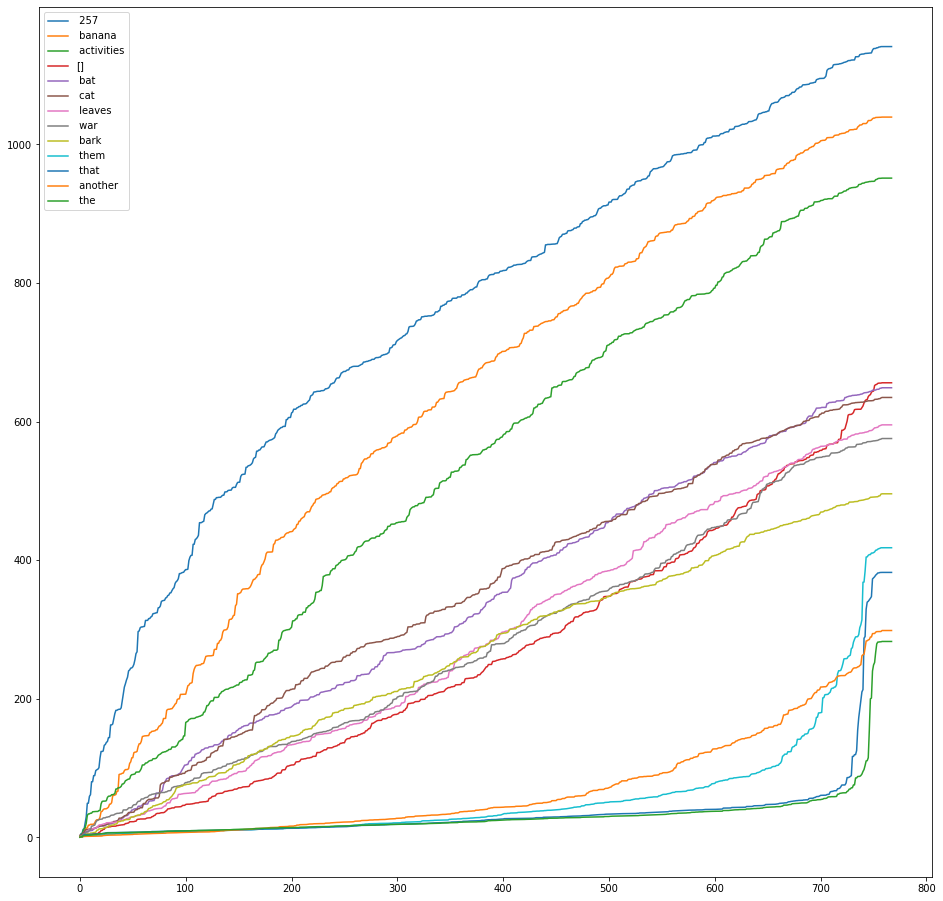

In [30]:
example_tokens = [' cat', ' war', ' banana', ' bat', ' bark', ' leaves', ' activities', ' another', ' that', ' them', ' the', '[]', ' 257']

def cumsum_graphs(example_tokens, sort=True):
    if sort:
        values = []
        for i, tok in enumerate(example_tokens):
            t, = encode(example_tokens[i])
            vec = V_to_D[t,:]
            score = (vec * vec).sum()
            values.append((score, tok))
        values.sort(reverse=True)
        sorted_tokens = [tok for i,tok in values]
    else:
        sorted_tokens = example_tokens

    for i, tok in enumerate(sorted_tokens):
        t, = encode(sorted_tokens[i])
        vec = V_to_D[t,:]
        ys = (vec * vec).cumsum(dim=0)
        plt.plot(range(d_D), ys, label = tok)
    plt.legend()

cumsum_graphs(example_tokens)


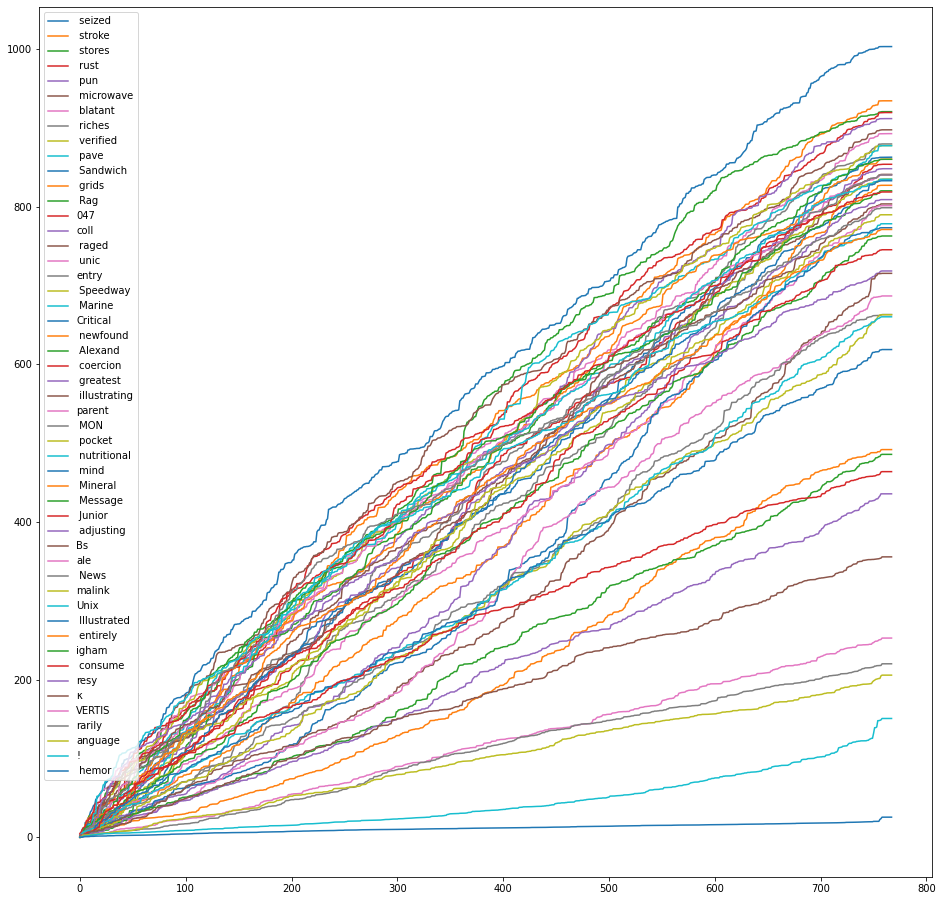

In [31]:
example_tokens = [decode(i) for i in range(0, d_V, 1000)]
cumsum_graphs(example_tokens)

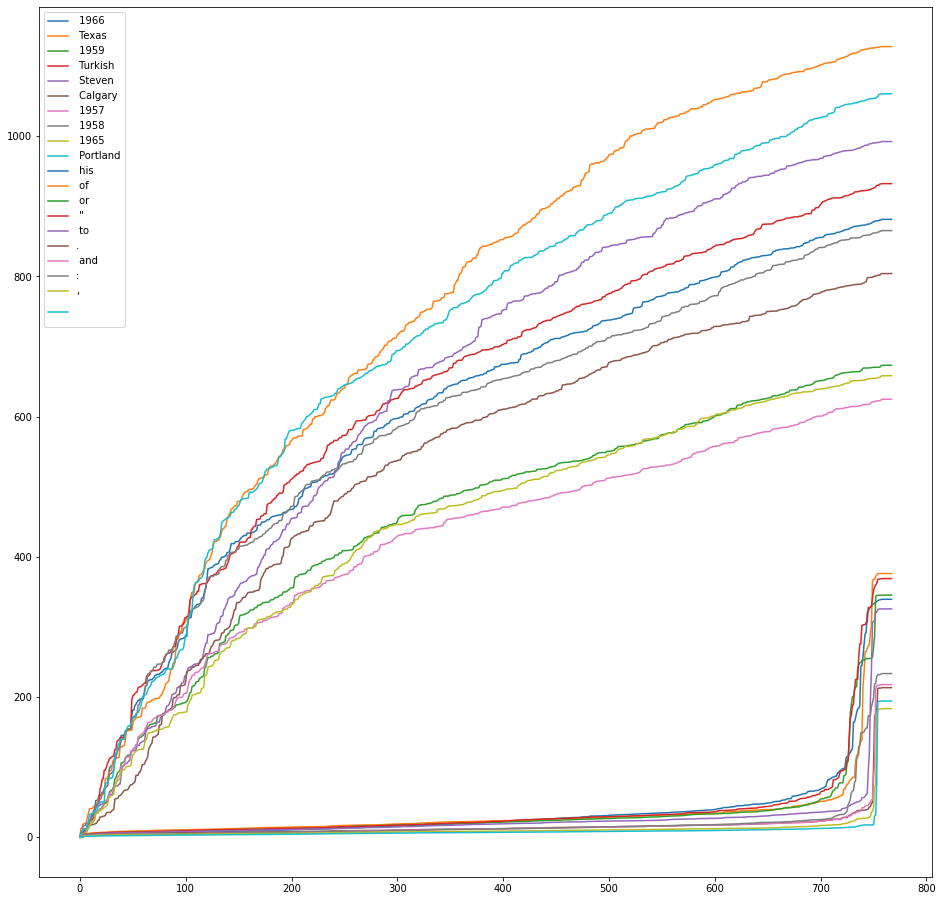

In [34]:
mid = (V_to_D[:,:d_D//2] ** 2).sum(dim=1)
tot = (V_to_D ** 2).sum(dim=1)
score = mid / tot
values = [(v.item(),i) for i,v in enumerate(score)]
values.sort()
toks = []
for i in range(10):
    toks.append(decode(values[i][1]))
for i in range(d_V-10,d_V):
    toks.append(decode(values[i][1]))
cumsum_graphs(list(reversed(toks)), sort=False)

In [38]:
for i in range(0,20):
    dd = torch.zeros((d_D,))
    dd[i] = 1
    print_similar(f"Principal component {i}", dd)

Principal component 0 1.0  FULL
  646                     3.339292526245117
  Adapt                  3.2665297985076904
  207                    3.2472097873687744
  368                    3.2208147048950195
  Client                  3.139962911605835
  570                     3.139594078063965
  Button                 3.1087234020233154
  Clinton                3.1019582748413086
  209                     3.079667329788208
  Total                  3.0403504371643066
  660                     3.006793975830078
  Menu                    2.970372438430786
  151                      2.96829891204834
  Bone                    2.967280626296997
  Bitcoin                2.9655418395996094
  199                     2.962339162826538
  465                     2.950895309448242
  Digital                2.9464468955993652
  VAL                     2.929230213165283
  Ron                    2.9200477600097656

Principal component 1 1.0  FULL
   Texas                 3.5179195404052734
   Carn    

  processing               4.98476505279541
  managed                 4.292309761047363
  blocking               4.1653876304626465
   malaria               4.1484856605529785
   leased                 4.007103443145752
  laun                    3.928727626800537
   Karachi               3.8971023559570312
  diagn                  3.8940787315368652
  supported               3.877748489379883
  manufact                3.853893518447876
  sector                 3.7867014408111572
  registered              3.770169258117676
  component              3.7642195224761963
  remote                 3.7342610359191895
  protein                3.7121777534484863
  vacc                   3.7052483558654785
  commercial             3.7007803916931152
  protection             3.6944804191589355
  breeding                  3.6581871509552
  computer                3.631084442138672

Principal component 11 1.0  FULL
   computational          4.368186950683594
   insightful             4.33319425582885

   execut                 4.826821804046631
   302                    4.339560031890869
   sheriff                4.304612159729004
   318                     4.28177547454834
   204                    4.208200454711914
   clerks                 4.190850734710693
   341                    4.144493579864502
   334                    4.139194488525391
   troopers               4.112802505493164
   244                    4.082786560058594
   409                    4.018425464630127
   guardians             3.9577691555023193
   COMM                  3.9570841789245605
   337                   3.9314565658569336
   331                   3.8929738998413086
   servant               3.8918910026550293
   124                     3.85504150390625
   incompetent           3.8525404930114746
   249                   3.8483917713165283
   294                   3.8312525749206543

